# Mathematical Underpinnings - Lab 10

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import scale

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import Lasso

## Task 1

In [4]:
df = pd.read_csv('../../../labs/prostate.data', sep="\t", index_col=0)

In [5]:
X = np.array(df.iloc[:, 0:8])
Y = np.array(df.iloc[:, 8])

In [6]:
X = scale(X)
Y = scale(Y)

### a)

In [7]:
mod_lars = Lars(fit_intercept=False)
# fit
mod_lars.fit(X, Y)

Lars(fit_intercept=False)

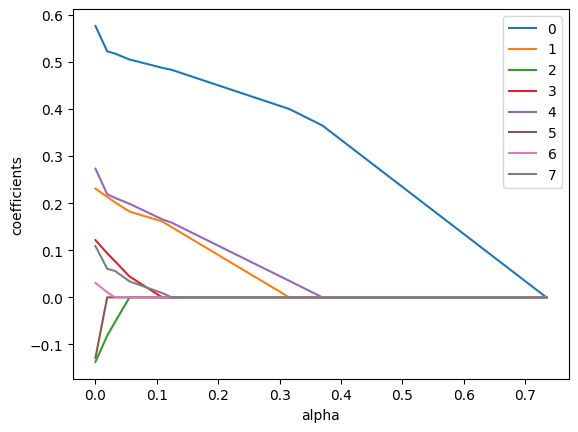

In [8]:
# plot
plt.figure()
plt.plot(mod_lars.alphas_, mod_lars.coef_path_.T)
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.legend(range(8))
plt.show()

Order in which the variables are included in the model:

In [9]:
# variables order: 0, 4, 1, 7, 3, 2, 6, 5
df.columns[[0, 4, 1, 7, 3, 2, 6, 5]].to_list()

['lcavol', 'svi', 'lweight', 'pgg45', 'lbph', 'age', 'gleason', 'lcp']

### b)

In [12]:
mod_lars.alphas_[0]

0.7344603262136732

In [13]:
# compute the first element of mod_lars.alphas_ vector - find the largest correlation between Y and X_i

# compute the first element of mod_lars.alphas_ vector
# find the largest correlation between Y and X_i
np.corrcoef(X[:, 0], Y)[0, 1]

0.7344603262136737

### b1)

In [14]:
selected_variables = []

In [15]:
# find the largest correlation between Y and X_i

for i in range(8):
    if np.corrcoef(X[:, i], Y)[0, 1] == np.max([np.corrcoef(X[:, j], Y)[0, 1] for j in range(8)]):
        selected_variables.append(i)

In [16]:
selected_variables

[0]

### b2)

In [17]:
mod1 = LinearRegression(fit_intercept=False)
mod1.fit(X[:, selected_variables], Y)
mod1.coef_

array([0.73446033])

### b3)

In [18]:
Y_hat = mod1.predict(X[:, selected_variables])

In [19]:
# code 
alpha_values = np.linspace(0, 1, 100)

correlations = []

for alpha in alpha_values:
    r1_alpha = Y - alpha * Y_hat
    
    corr = [np.corrcoef(r1_alpha, X[:, i])[0, 1] for i in range(X.shape[1])]
    correlations.append(corr)

correlations = np.array(correlations)

In [20]:
correlations.shape

(100, 8)

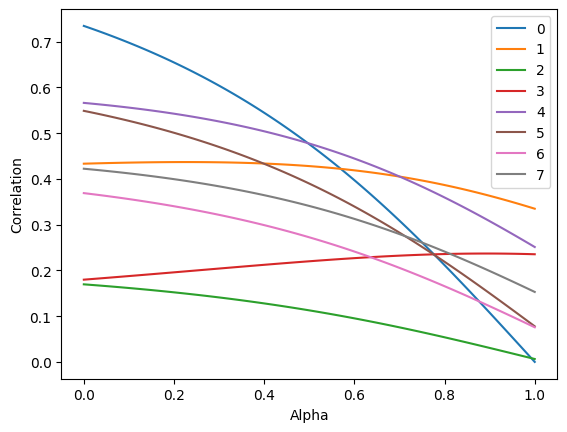

In [21]:
# plot

plt.figure()
for i in range(X.shape[1]):
    plt.plot(alpha_values, correlations[:, i], label=i)
plt.xlabel('Alpha')
plt.ylabel('Correlation')
plt.legend()
plt.show()

### b4)

In [22]:
# based on the plot, variable 4 should be chosen next
# approximate value of alpha_2_tilda is 0.5
alpha_2_tilda = 0.5
r1_alpha = Y - alpha_2_tilda * Y_hat

# correlations are almost the same
np.corrcoef(r1_alpha, X[:, 0])[0, 1], np.corrcoef(r1_alpha, X[:, 4])[0, 1] 

(0.4759095723474519, 0.4773453757968736)

### b5)

$$ \textrm{Cor}(Y - \tilde\alpha\hat Y, X_i) = ... \cdot\textrm{Cor}(Y, X_i) - ... \cdot \tilde\alpha \cdot \textrm{Cor}(\tilde\alpha\hat Y, X_i) $$

In our case, $i=0$, $j=4$:
$$ |\textrm{Cor}(Y - \tilde\alpha\hat Y, X_i)| = |\textrm{Cor}(Y - \tilde\alpha\hat Y, X_j)|$$

In [23]:
# code
alpha_values = np.linspace(0, 1, 100)

l = []

for alpha in alpha_values:
    std_Y = Y.std()
    std_Y_hat = Y_hat.std()

    diff = [std_Y * np.corrcoef(Y, X[:, i])[0, 1] - std_Y_hat * alpha * np.corrcoef(Y_hat, X[:, i])[0, 1] for i in range(X.shape[1])]
    l.append(diff)

l = np.array(l)

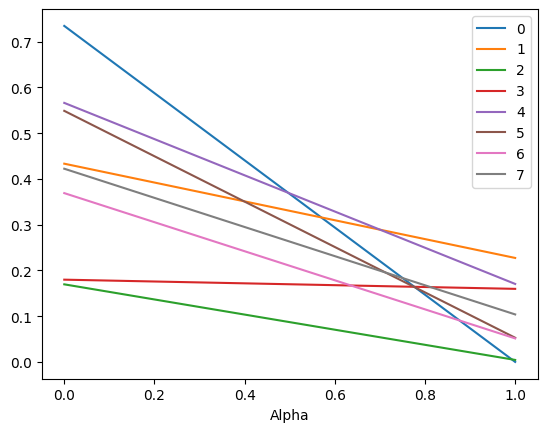

In [24]:
# plot
plt.figure()
for i in range(X.shape[1]):
    plt.plot(alpha_values, l[:, i], label=i)
plt.xlabel('Alpha')
plt.legend()
plt.show()

In [25]:
nominator = std_Y * np.corrcoef(Y, X[:, 0])[0, 1] - std_Y * np.corrcoef(Y, X[:, 4])[0, 1]
denominator = std_Y_hat * np.corrcoef(Y_hat, X[:, 0])[0, 1] - std_Y_hat * np.corrcoef(Y_hat, X[:, 4])[0, 1]
alpha_2_tilda = nominator / denominator

### b6)

In [36]:
r1_alpha2 = Y - alpha_2_tilda * Y_hat

alpha_2 = std_Y * np.corrcoef(Y, X[:, 4])[0, 1] - alpha_2_tilda * std_Y_hat * np.corrcoef(Y_hat, X[:, 4])[0, 1]

selected_variables = [0, 4]

In [33]:
alpha_2

0.36963265526107464

In [34]:
# alpha_2 is correct - equal to the second element of
mod_lars.alphas_

array([0.73446033, 0.36963266, 0.3157    , 0.12438766, 0.10869606,
       0.05558212, 0.03210302, 0.01913394, 0.        ])

### b7)

In [37]:
mod2 = LinearRegression(fit_intercept=False)
mod2.fit(X[:, selected_variables], r1_alpha2)
mod2.coef_

array([0.24020136, 0.24020136])

In [38]:
Y2_hat = mod2.predict(X[:, selected_variables])

### b8)

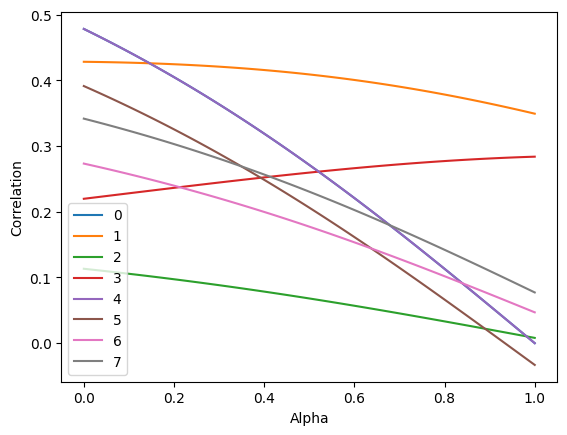

In [40]:
alpha_values = np.linspace(0, 1, 100)

correlations = []

for alpha in alpha_values:
    r2_alpha = r1_alpha2 - alpha * Y2_hat
    
    corr = [np.corrcoef(r2_alpha, X[:, i])[0, 1] for i in range(X.shape[1])]
    correlations.append(corr)

correlations = np.array(correlations)

plt.figure()
for i in range(X.shape[1]):
    plt.plot(alpha_values, correlations[:, i], label=i)
plt.xlabel('Alpha')
plt.ylabel('Correlation')
plt.legend()
plt.show()

### b9)

In [41]:
# based on the plot, variable 1 should be chosen next
# approximate value of alpha_3_tilda is 0.15

### b10)

In [43]:
nominator = r1_alpha2.std() * np.corrcoef(r1_alpha2, X[:, 0])[0, 1] - r1_alpha2.std() * np.corrcoef(r1_alpha2, X[:, 1])[0, 1]
denominator =  Y2_hat.std() * np.corrcoef(Y2_hat, X[:, 0])[0, 1] - Y2_hat.std() * np.corrcoef(Y2_hat, X[:, 1])[0, 1]
alpha_3_tilda = nominator / denominator
alpha_3_tilda

0.14590879649354682

### b11)

In [51]:
r1_alpha3 = r1_alpha2 - alpha_3_tilda * Y2_hat

alpha_3 = r1_alpha2.std() * np.corrcoef(r1_alpha2, X[:, 1])[0, 1] - alpha_3_tilda * Y2_hat.std() * np.corrcoef(Y2_hat, X[:, 1])[0, 1]


selected_variables = [0, 4, 1]

In [52]:
alpha_3

0.3156999993872169

In [53]:
# alpha_3 is correct - equal to the third element of
mod_lars.alphas_

array([0.73446033, 0.36963266, 0.3157    , 0.12438766, 0.10869606,
       0.05558212, 0.03210302, 0.01913394, 0.        ])